In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

2024-06-15 10:31:46.499663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 10:31:46.657213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-15 10:31:46.657232: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-15 10:31:47.347267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [4]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Dataset/ADBE_Stock.csv')
df1=df.reset_index()['Close']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

2024-06-15 10:31:49.348145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-15 10:31:49.348238: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-15 10:31:49.348354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Tu): /proc/driver/nvidia/version does not exist
2024-06-15 10:31:49.348809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 132ms/step - loss: 0.1082 - val_loss: 0.0098
Epoch 2/100
13/13 [==============================] - 1s 113ms/step - loss: 0.0193 - val_loss: 0.0040
Epoch 3/100
13/13 [==============================] - 1s 101ms/step - loss: 0.0093 - val_loss: 0.0101
Epoch 4/100
13/13 [==============================] - 1s 102ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 5/100
13/13 [==============================] - 1s 112ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/100
13/13 [==============================] - 1s 106ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/100
13/13 [==============================] - 1s 104ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100
13/13 [==============================] - 1s 104ms/step - loss: 0.0011 - val_lo

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 14ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
# y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 514.2095014974894


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.42582223]
339
1 day input [0.26658671 0.29790377 0.31706757 0.28731865 0.27786364 0.29767314
 0.28508171 0.27920115 0.26808567 0.2773332  0.28402092 0.27950096
 0.25464106 0.23547726 0.21207022 0.21672854 0.21280812 0.15174228
 0.15584716 0.15960614 0.15829163 0.18162949 0.20593595 0.21280812
 0.20768855 0.21008692 0.19286025 0.17194379 0.16034404 0.18123742
 0.18188313 0.2272675  0.23845216 0.24938312 0.27553444 0.24668494
 0.26349652 0.27724094 0.27306688 0.27364341 0.28692665 0.29324537
 0.30124759 0.28904823 0.30074024 0.2935221  0.29024745 0.28021585
 0.26836239 0.265549   0.28609641 0.28743399 0.28406709 0.28321377
 0.28911741 0.28946338 0.28349056 0.2827295  0.26485712 0.2497982
 0.26907735 0.28323685 0.27537299 0.26271245 0.20872633 0.18700271
 0.21599057 0.20598205 0.20273042 0.20588978 0.20026286 0.18612644
 0.20969492 0.20840344 0.23496991 0.24373311 0.26868528 0.27053014
 0.26677124 0.25602474 0.3166755  0.37047716 0.37467424 0.37601182
 0.39667458 0.41885938 0.41380899 

In [16]:
# 13. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.42582223]
339
1 day input [0.26658671 0.29790377 0.31706757 0.28731865 0.27786364 0.29767314
 0.28508171 0.27920115 0.26808567 0.2773332  0.28402092 0.27950096
 0.25464106 0.23547726 0.21207022 0.21672854 0.21280812 0.15174228
 0.15584716 0.15960614 0.15829163 0.18162949 0.20593595 0.21280812
 0.20768855 0.21008692 0.19286025 0.17194379 0.16034404 0.18123742
 0.18188313 0.2272675  0.23845216 0.24938312 0.27553444 0.24668494
 0.26349652 0.27724094 0.27306688 0.27364341 0.28692665 0.29324537
 0.30124759 0.28904823 0.30074024 0.2935221  0.29024745 0.28021585
 0.26836239 0.265549   0.28609641 0.28743399 0.28406709 0.28321377
 0.28911741 0.28946338 0.28349056 0.2827295  0.26485712 0.2497982
 0.26907735 0.28323685 0.27537299 0.26271245 0.20872633 0.18700271
 0.21599057 0.20598205 0.20273042 0.20588978 0.20026286 0.18612644
 0.20969492 0.20840344 0.23496991 0.24373311 0.26868528 0.27053014
 0.26677124 0.25602474 0.3166755  0.37047716 0.37467424 0.37601182
 0.39667458 0.41885938 0.41380899 

In [17]:
# 13. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.42582223]
339
1 day input [0.26658671 0.29790377 0.31706757 0.28731865 0.27786364 0.29767314
 0.28508171 0.27920115 0.26808567 0.2773332  0.28402092 0.27950096
 0.25464106 0.23547726 0.21207022 0.21672854 0.21280812 0.15174228
 0.15584716 0.15960614 0.15829163 0.18162949 0.20593595 0.21280812
 0.20768855 0.21008692 0.19286025 0.17194379 0.16034404 0.18123742
 0.18188313 0.2272675  0.23845216 0.24938312 0.27553444 0.24668494
 0.26349652 0.27724094 0.27306688 0.27364341 0.28692665 0.29324537
 0.30124759 0.28904823 0.30074024 0.2935221  0.29024745 0.28021585
 0.26836239 0.265549   0.28609641 0.28743399 0.28406709 0.28321377
 0.28911741 0.28946338 0.28349056 0.2827295  0.26485712 0.2497982
 0.26907735 0.28323685 0.27537299 0.26271245 0.20872633 0.18700271
 0.21599057 0.20598205 0.20273042 0.20588978 0.20026286 0.18612644
 0.20969492 0.20840344 0.23496991 0.24373311 0.26868528 0.27053014
 0.26677124 0.25602474 0.3166755  0.37047716 0.37467424 0.37601182
 0.39667458 0.41885938 0.41380899 

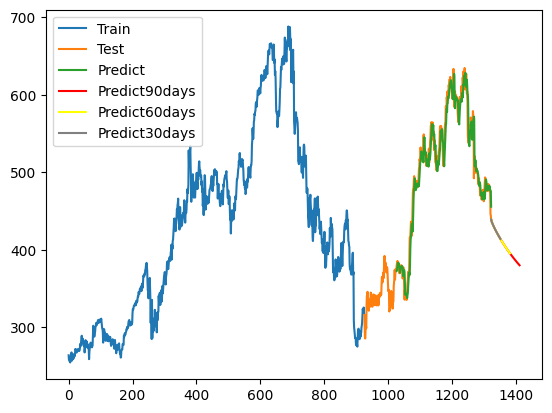

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.show()

In [21]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100
# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((y_pred - ytest) ** 2))
test_mape = calculate_mape(ytest, y_pred)
test_mda = calculate_mda(ytest, y_pred)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MDA:', test_mda)


Testing RMSE: 514.2095014974894
Testing MAPE: 98279.43436610878
Testing MDA: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
